# Trabalho MVP 
### 	Bruno Gazoni 7585037<br> 	Matheus Steigenberg Populim 10734710<br> Rafael Ceneme 	9898610<br> 	Bruno Baldissera  10724351

# Importando as bibliotecas necessárias

In [2]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Lendo a imagem de entrada

In [15]:
name1 = "img13.png"
A = imageio.imread(name1)
print(A.shape)

(1500, 1500, 3)


In [ ]:
def get_average_filter(A):
    N = A.shape[0] # size of img
    n = 100
    C = np.zeros((N//n,N//n),dtype=np.float32)


    for i in range(N//n):
        for j in range(N//n):
            C[i,j] = np.average(A[i*n:(i+1)*n,j*n:(j+1)*n])


    C = np.kron(C,np.ones((n,n)))

    return C

def normalize_one(A):
    a = A.min()
    b = A.max()
    A = ((A-a)/(b-a))
    return A

def gamma_correction(A,gamma):
    B = np.zeros((A.shape))
    B = 255*(np.power(A/255.0,1.0/gamma))
    B = normalize(B)
    return B

def normalize(A):
    a = A.min()
    b = A.max()
    A = ((A-a)/(b-a))*255
    A = A.astype(np.uint8)
    return A


img_hsv = mpl.colors.rgb_to_hsv(A)

teste = 1-img_hsv[:,:,1]


media = get_average_filter(teste)

teste = normalize_one(teste - media)
print(teste)
teste_gamma = gamma_correction(teste,0.8)
print(teste_gamma)

In [ ]:
valor = img_hsv[:,:,2]
print(valor, "aqui em cima")
print("aqui")

f_tr = np.ones(teste.shape).astype(np.uint8)
# setting to 0 the pixels below the threshold
# f_tr = A[:,:,0]
A[(np.where((teste_gamma > 180) & (valor < 200) & (valor > 90)))] = [255,0,0]

plt.imshow(A)
plt.show()



plt.show()

In [ ]:
!pip install scikit-image

In [4]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line

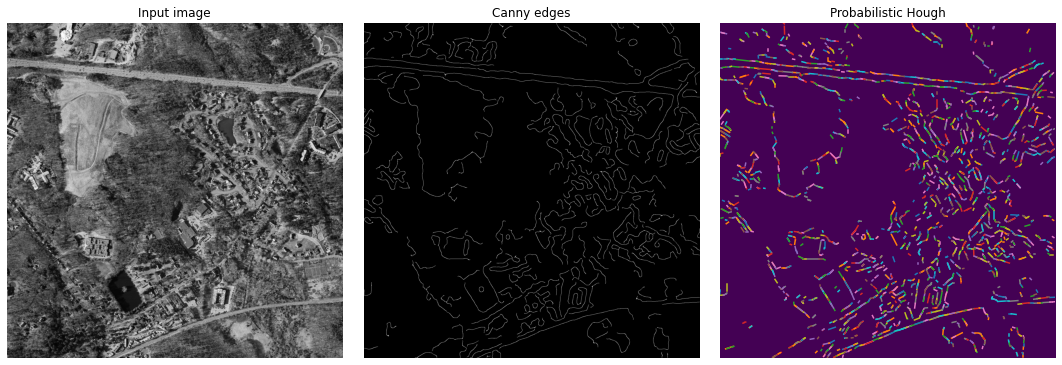

In [20]:
from skimage.transform import probabilistic_hough_line

# Line finding using the Probabilistic Hough Transform
image = A[:,:,0]
edges = canny(image, 8, 1, 25)
lines = probabilistic_hough_line(edges, threshold=40, line_length=5,
                                 line_gap=3)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=mpl.cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=mpl.cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()